In [1]:
import sys

sys.path.insert(
    1, "..\\utilities\\"
)  # adds utilities folder to path so we can import modules from it, won't be needed after packaging

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import loading_utils as load
import preprocessing_utils as prep

participant_list = [200, 201, 202, 204, 205, 206, 207, 209, 210, 211, 212, 213]

# Plots of first 30 s after adaptation phase for participant 201.

The vertical lines are spaced every 0.25 s.

In [17]:

data_dir = "./results/new/"
data_suffix = "_recording_data.csv"
participant_id = 201

data_path = os.path.join(data_dir, str(participant_id) + data_suffix)
data_df = pd.read_csv(data_path,usecols=['Overall time Sec','Stim eye - Size Mm','Trial no','Trial type','Trial time Sec','Trial phase','Left - Size Mm','Right - Size Mm','Eye','Recording id','Block','Test'])



In [ ]:
quarter_second_list = np.arange(240,270.25,0.25)

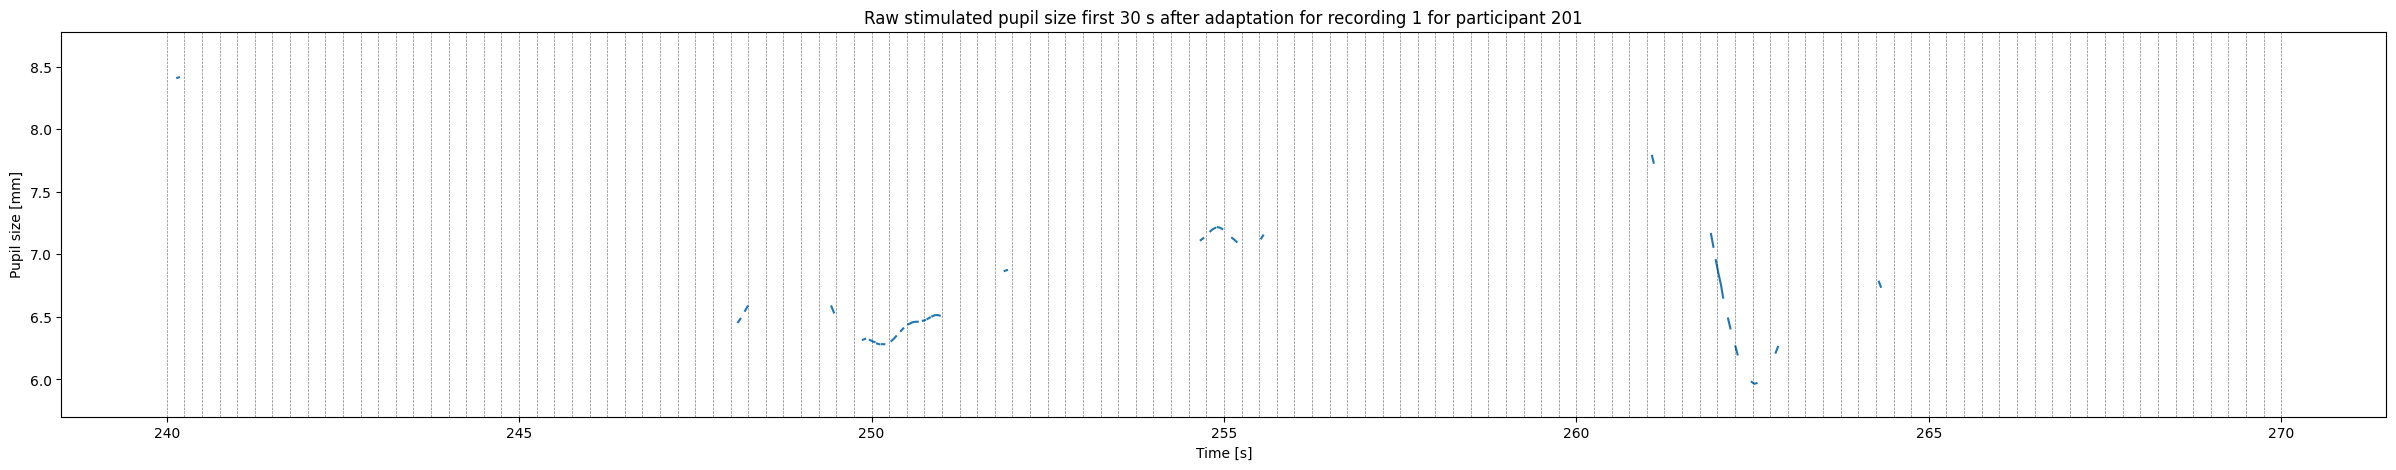

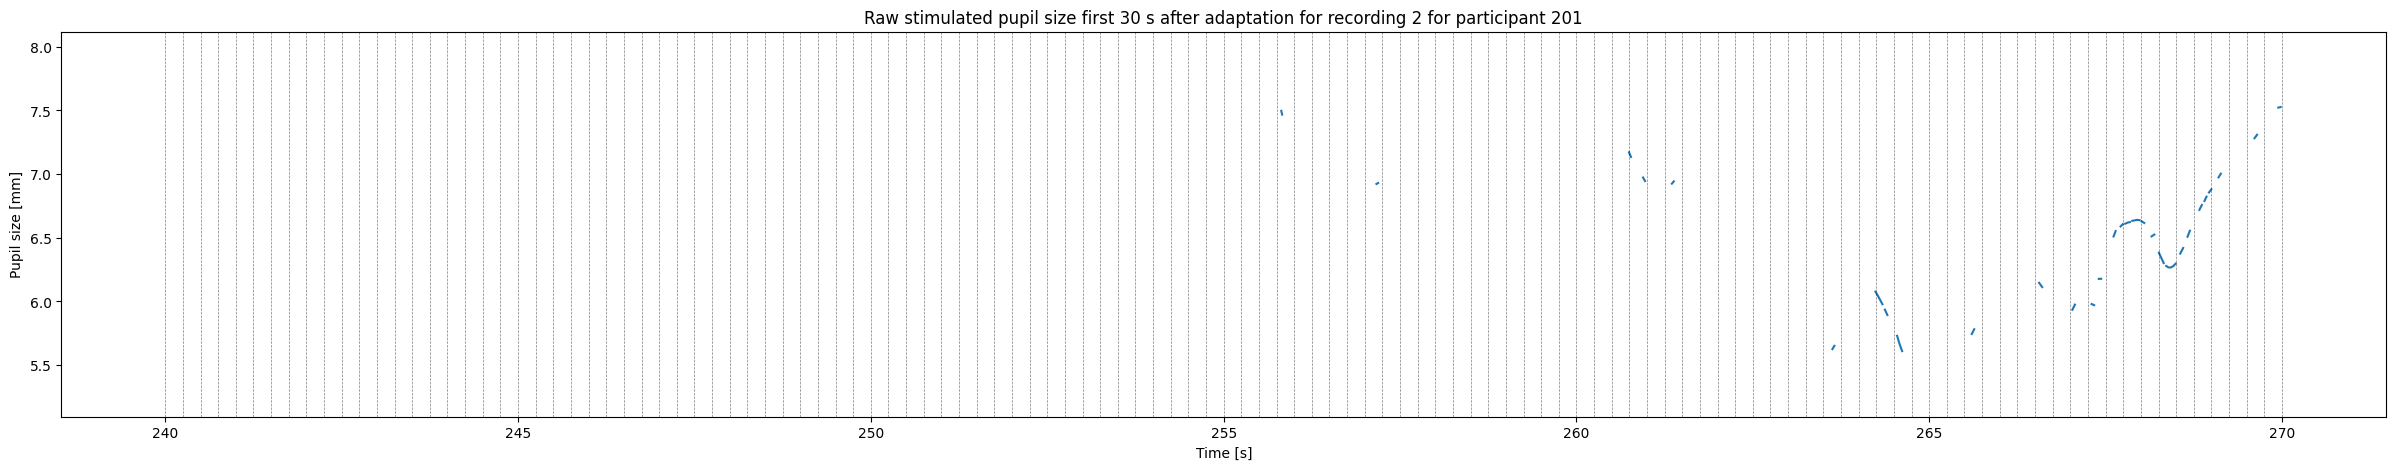

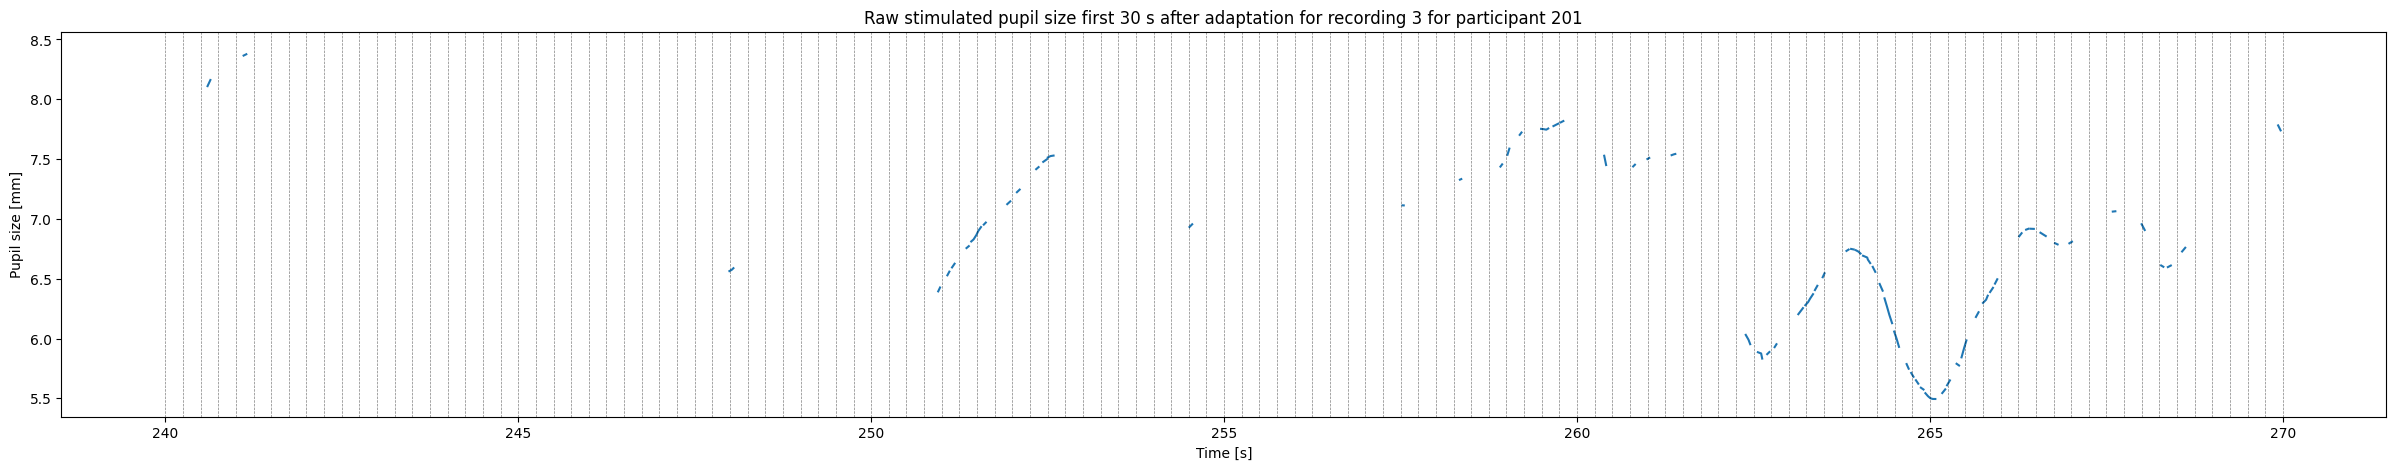

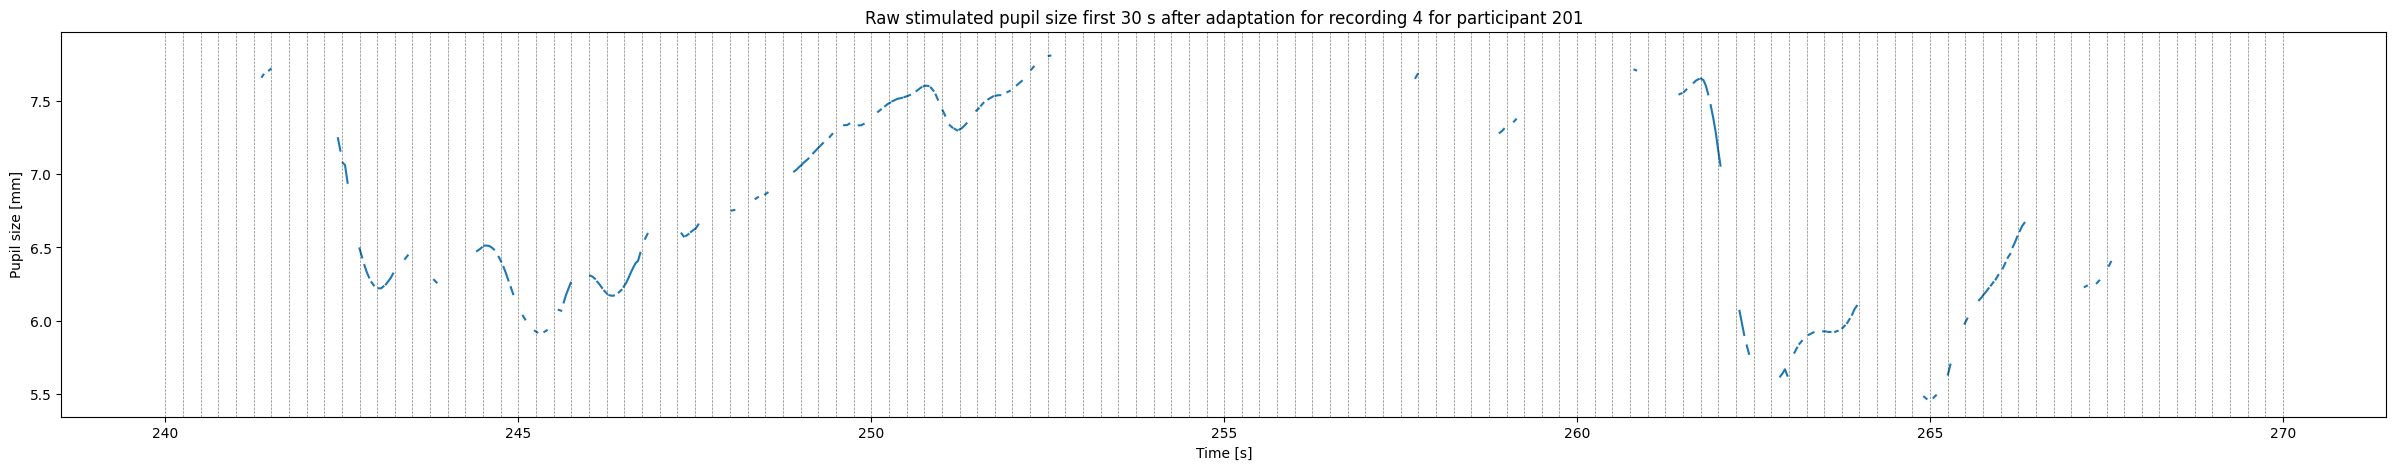

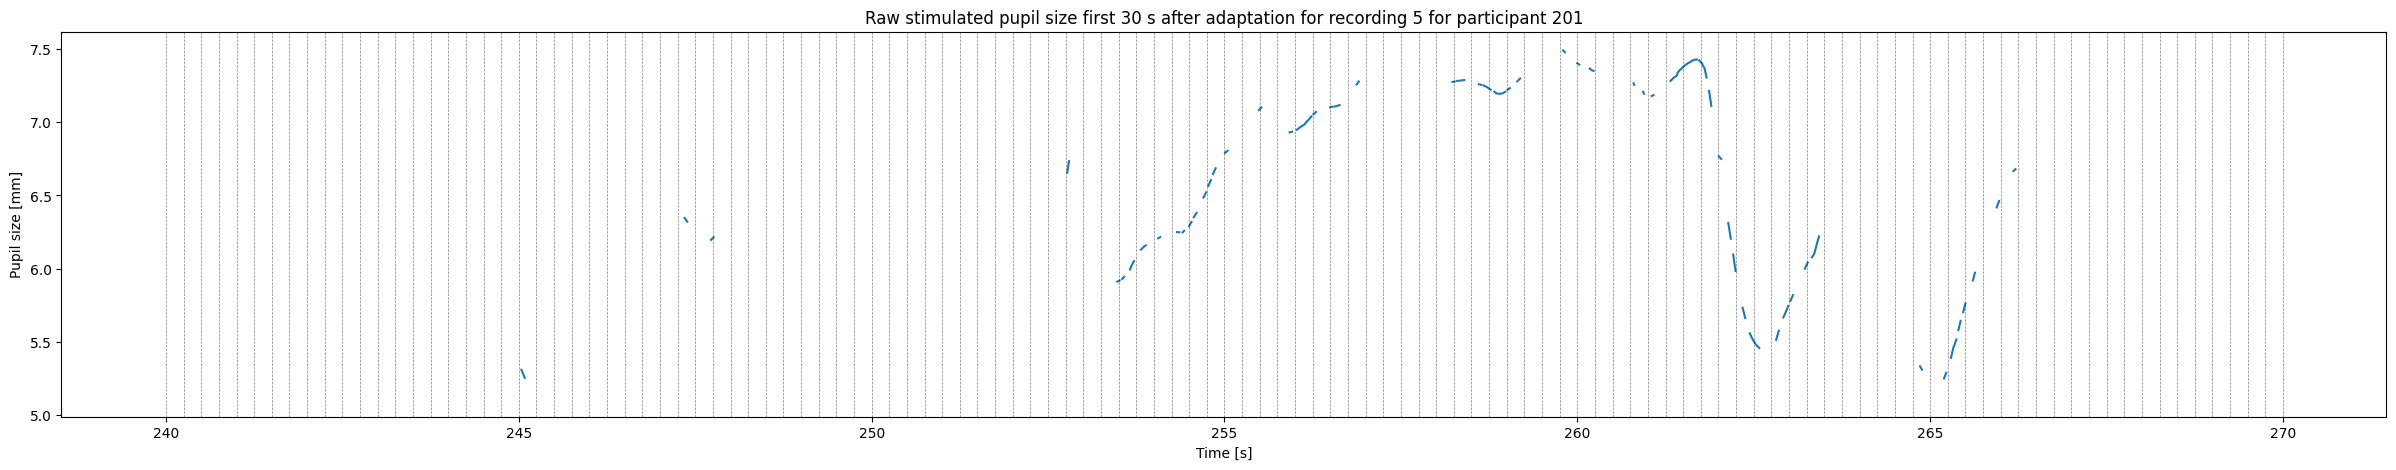

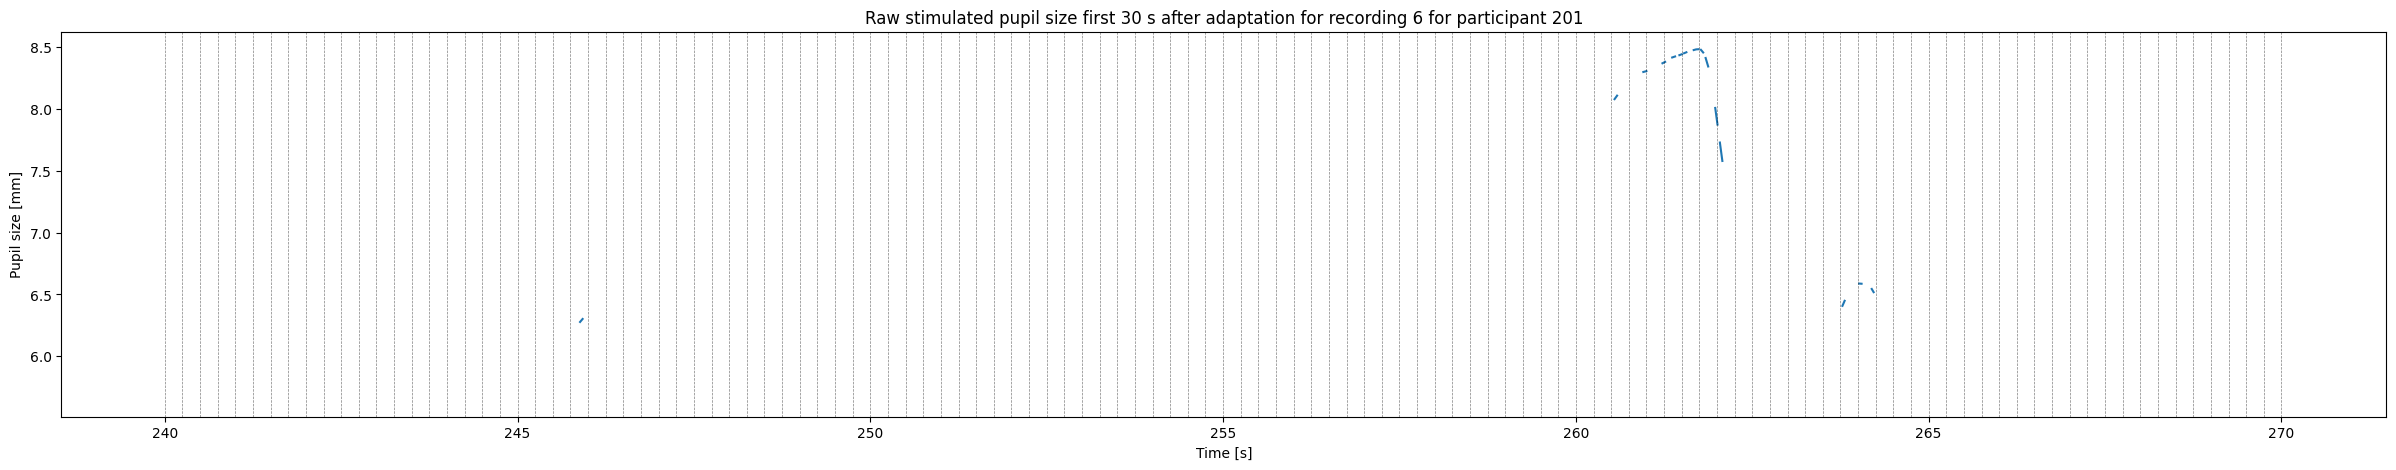

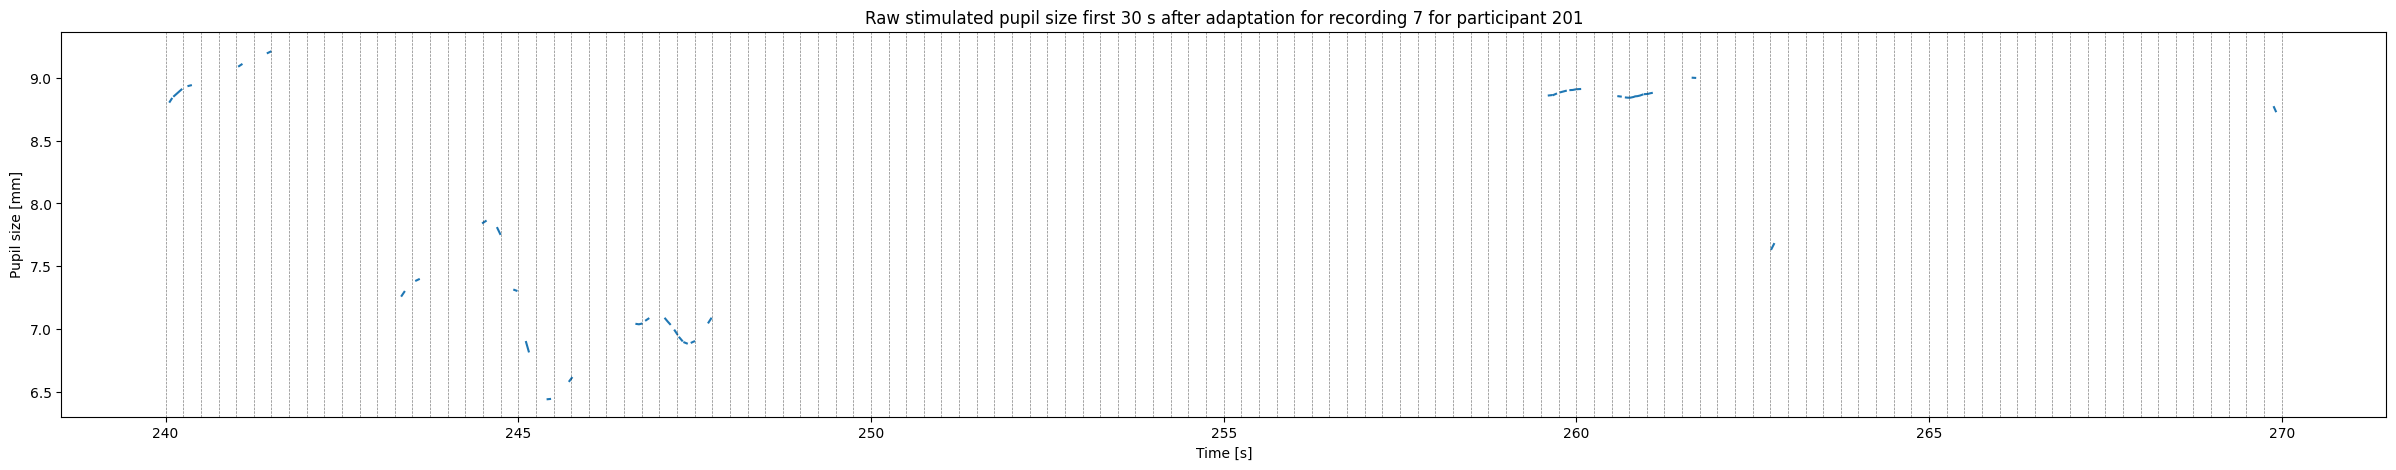

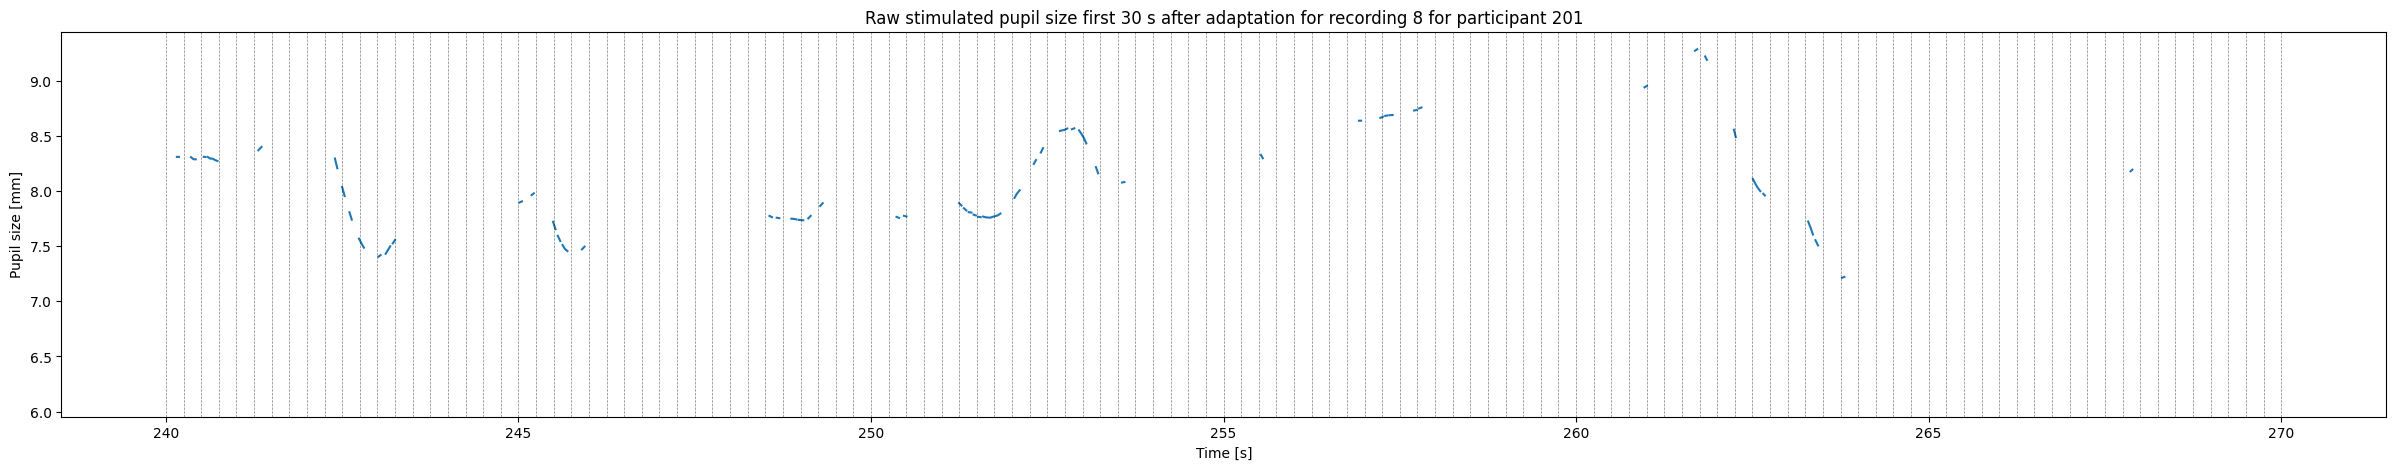

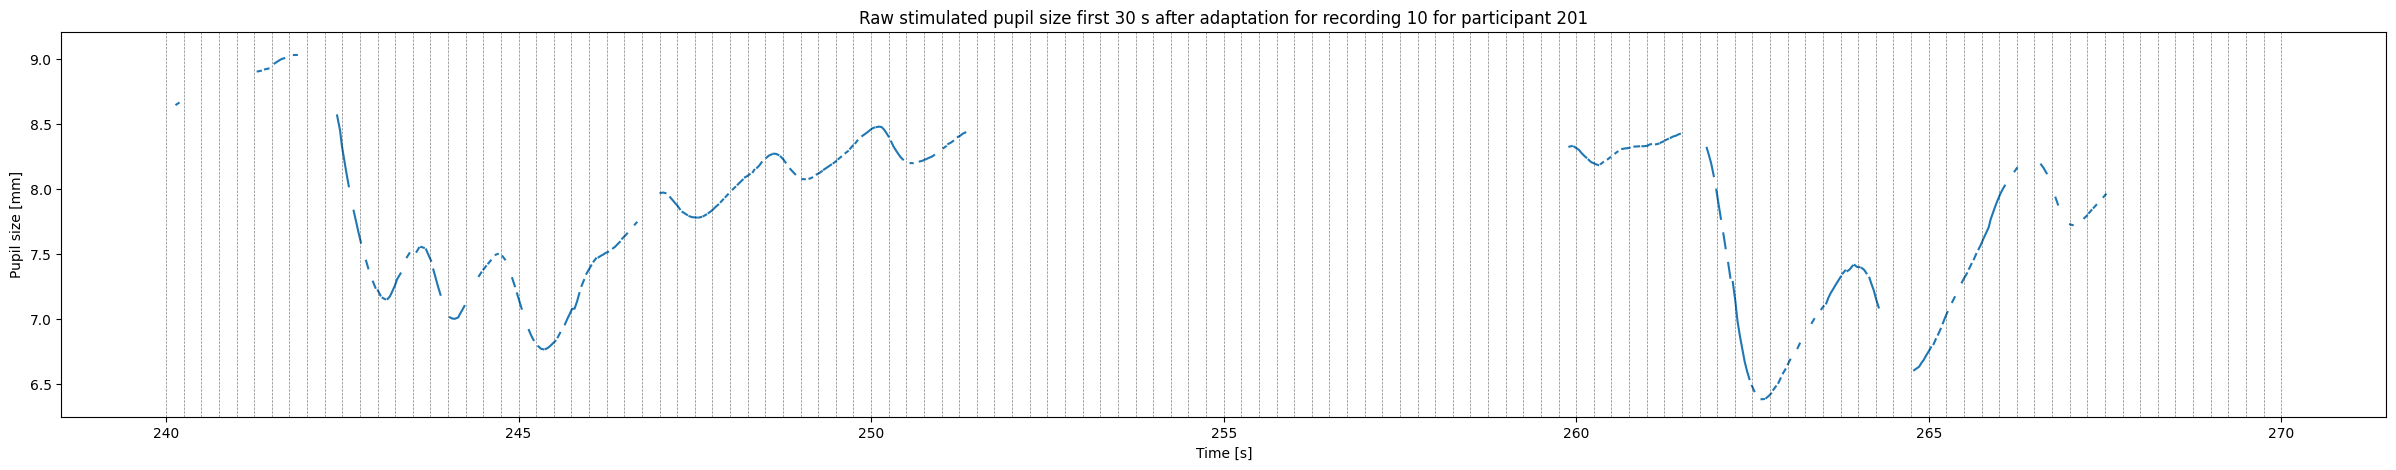

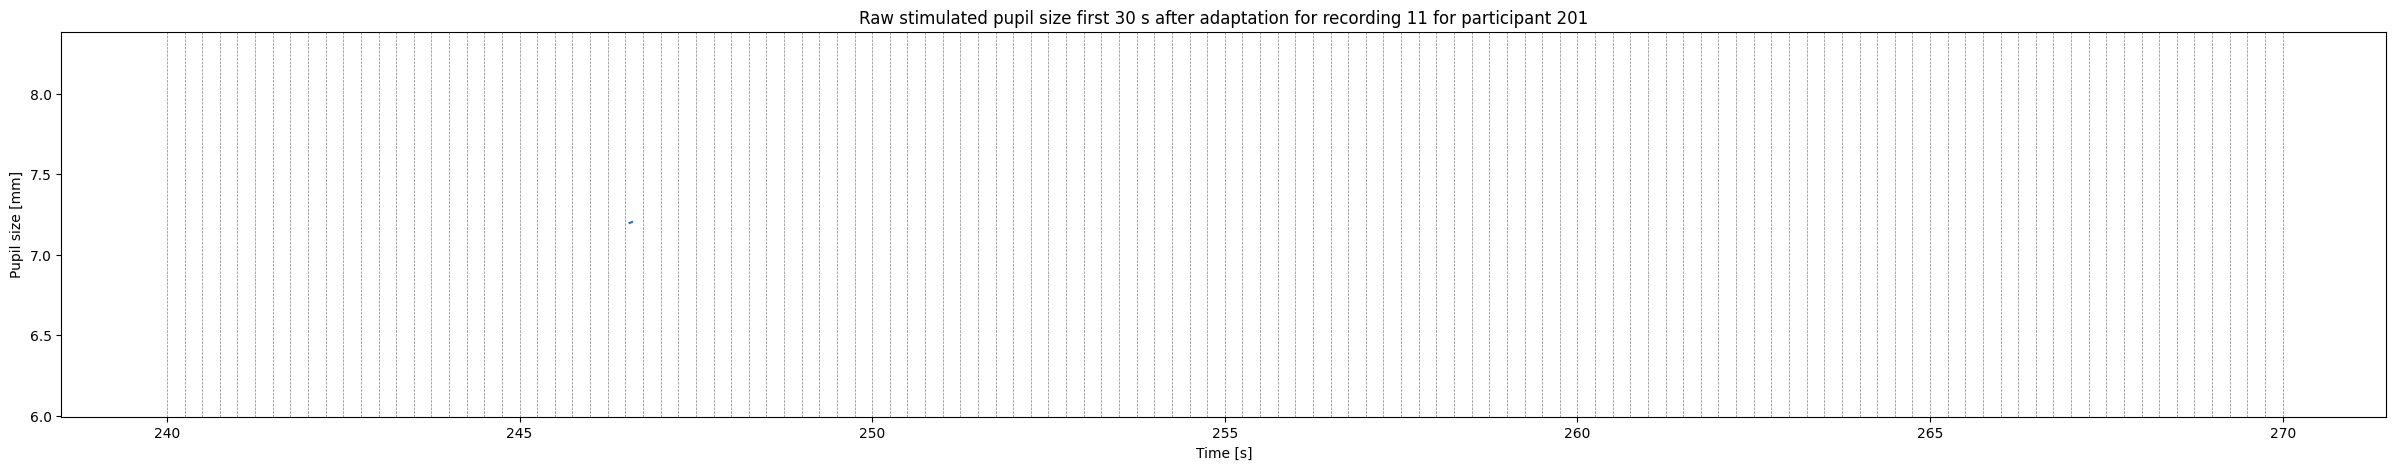

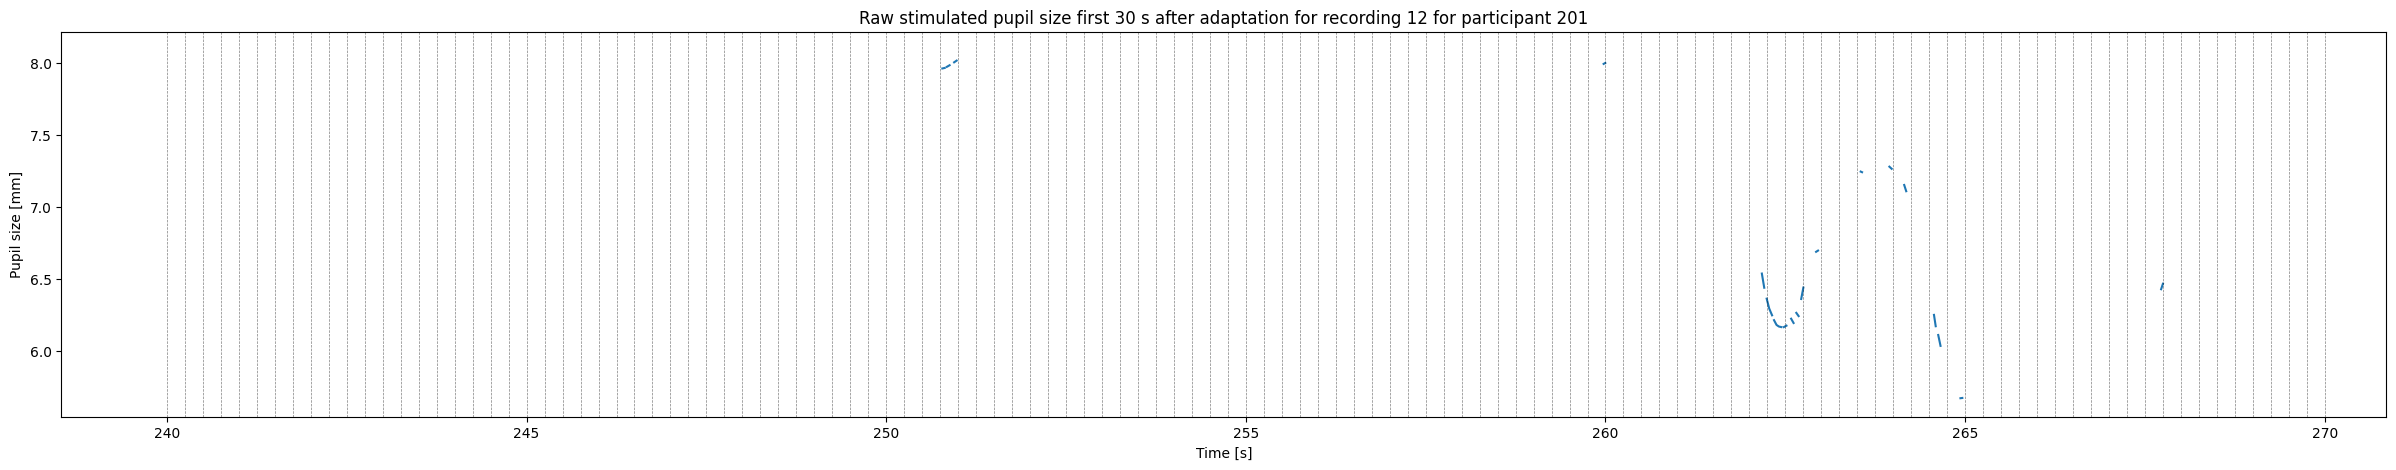

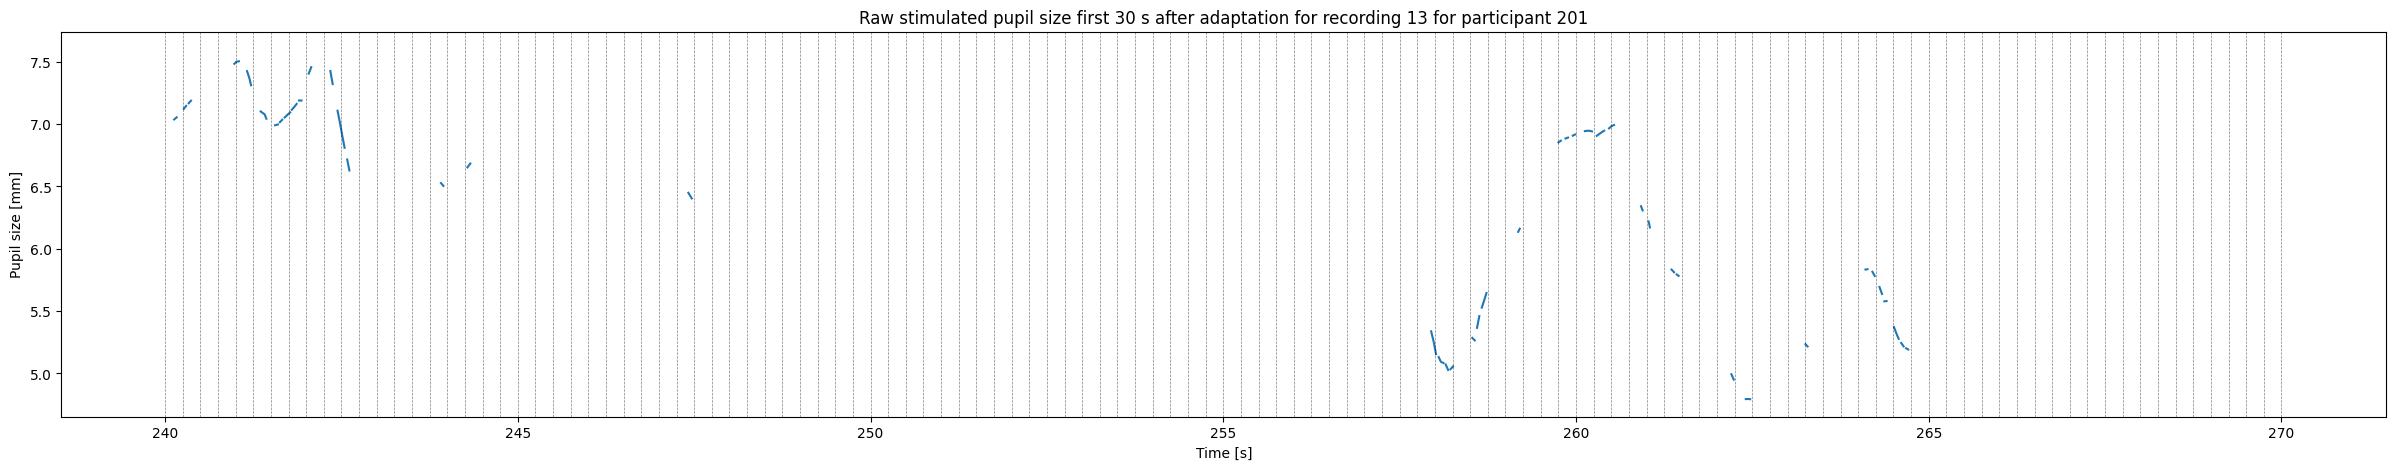

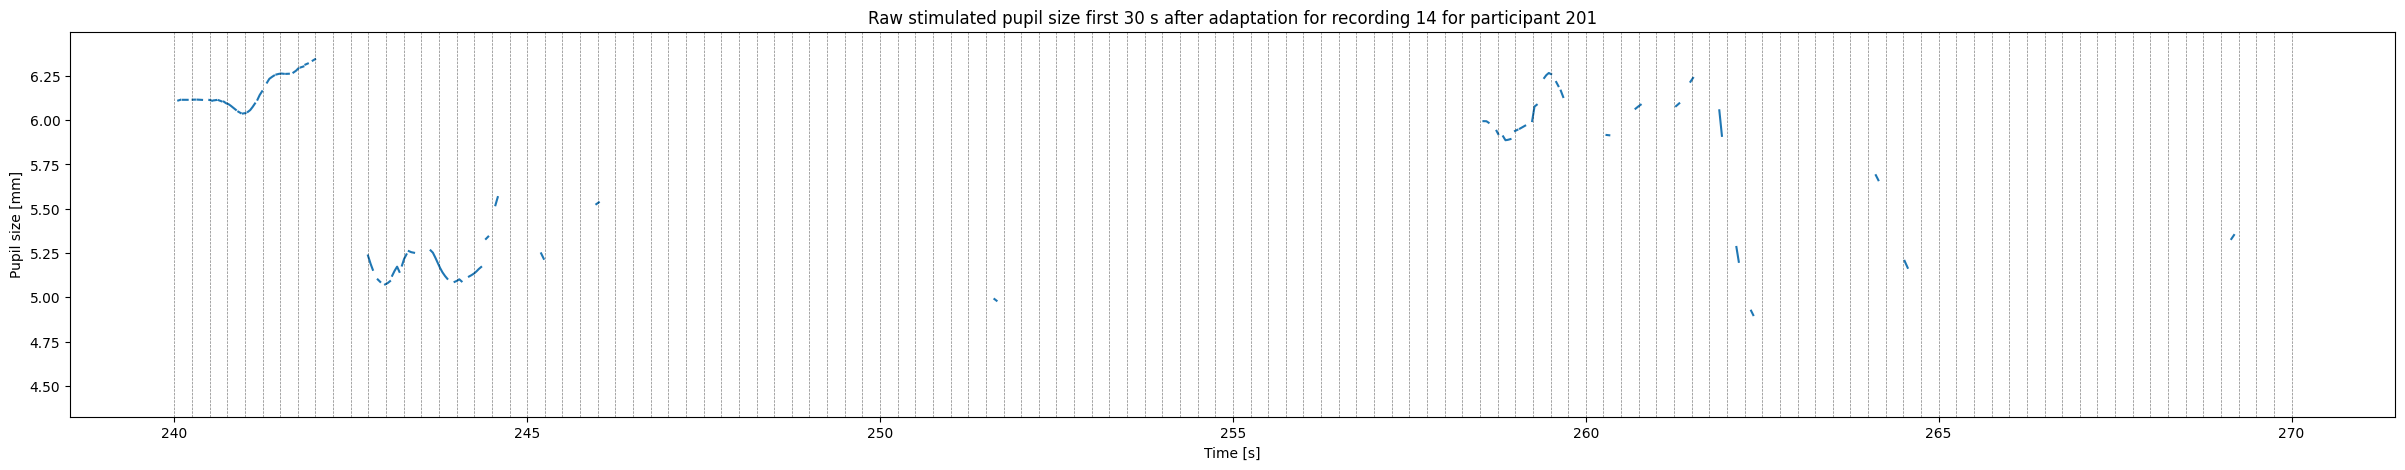

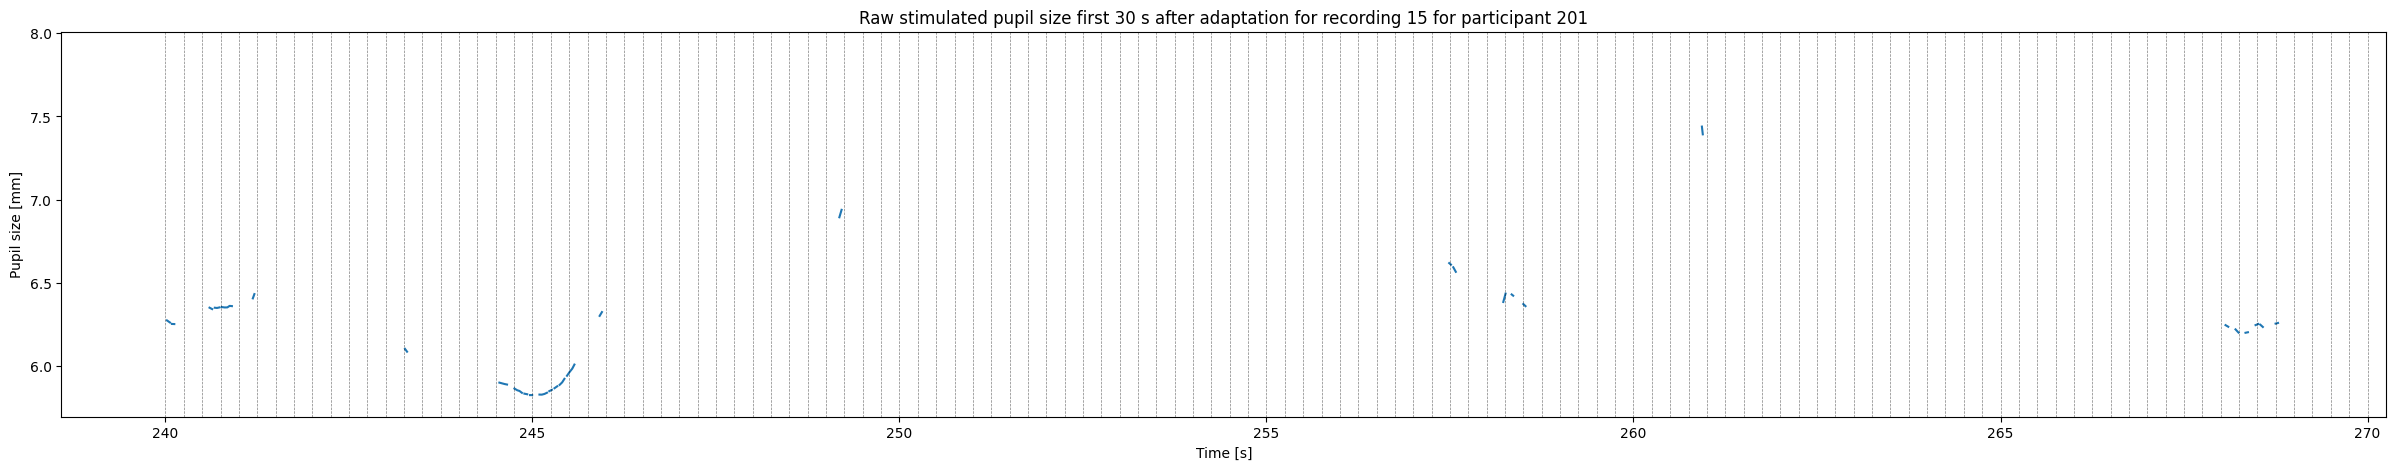

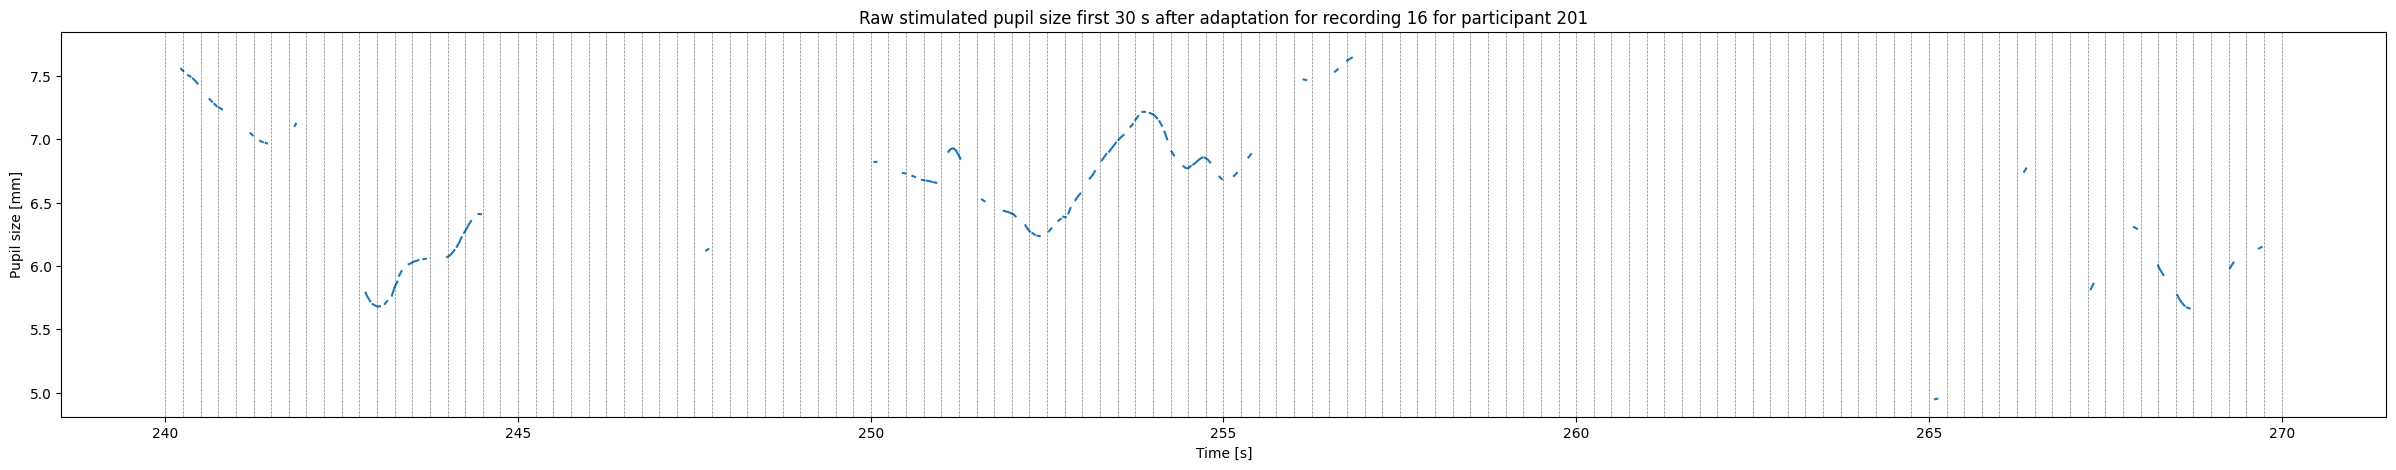

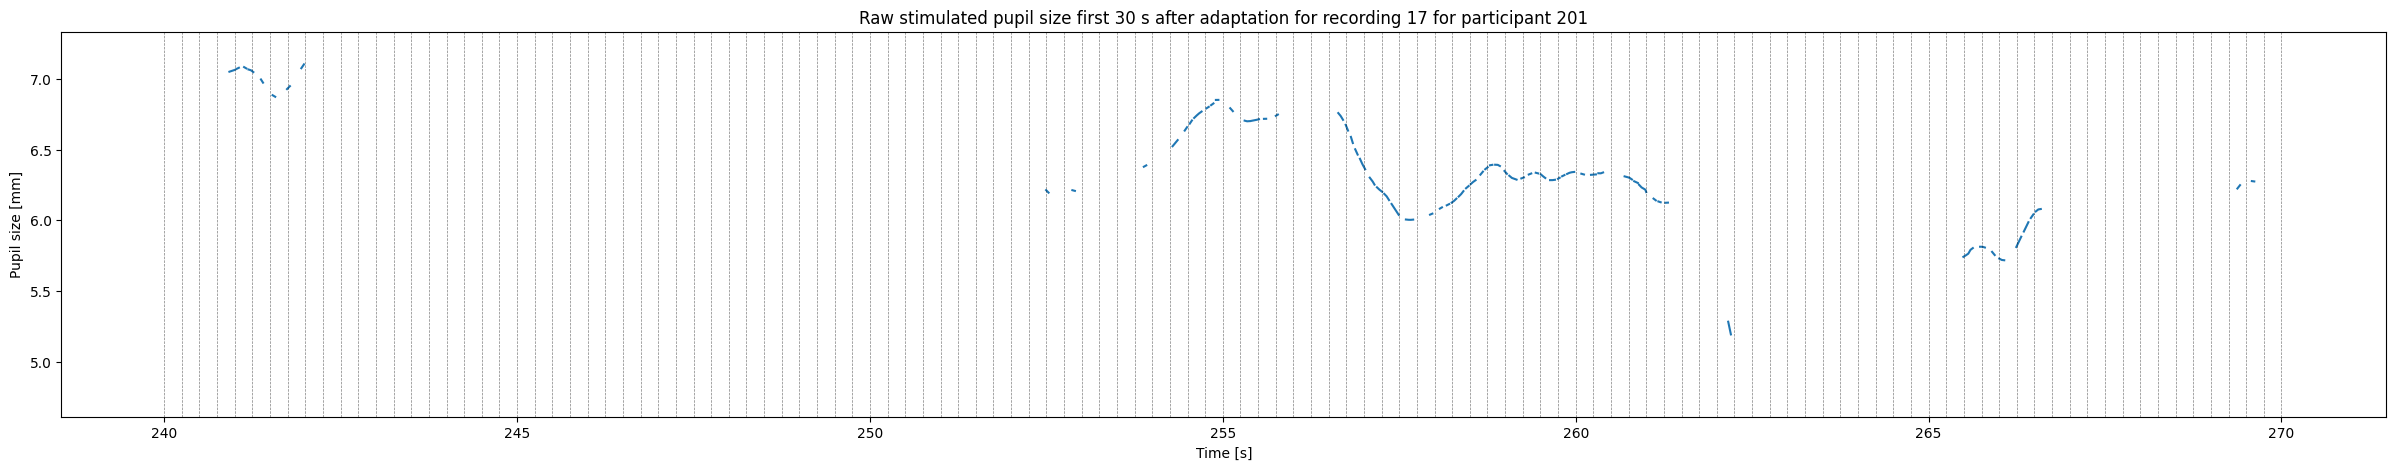

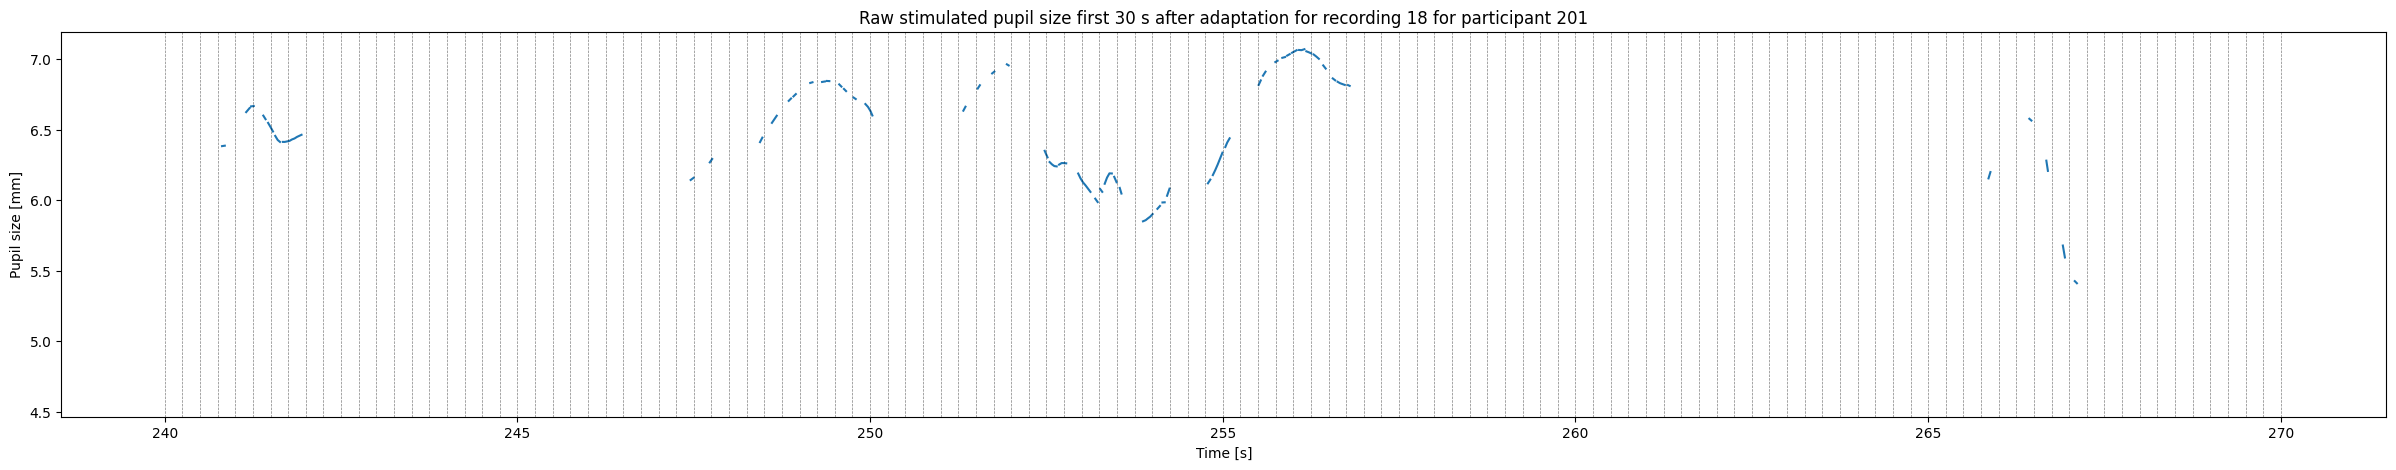

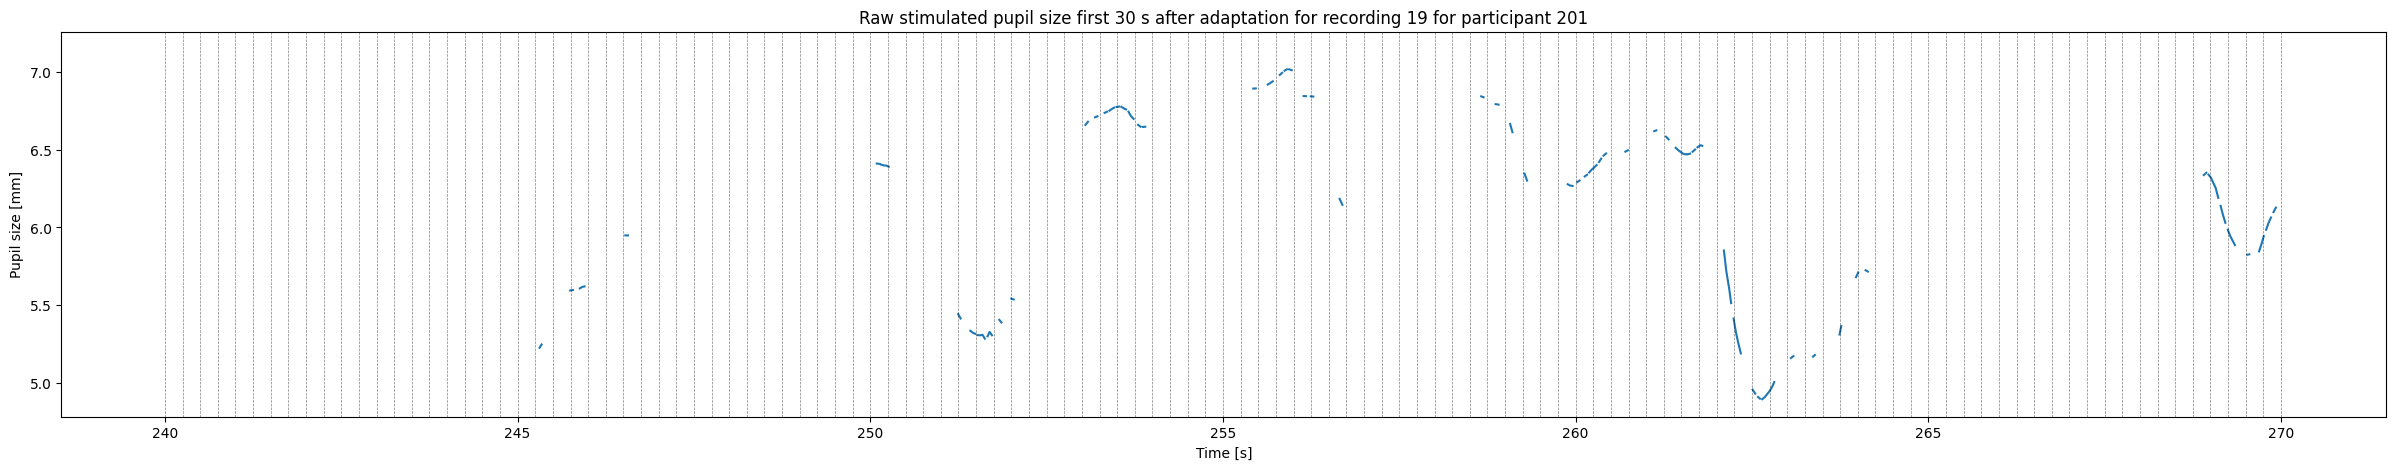

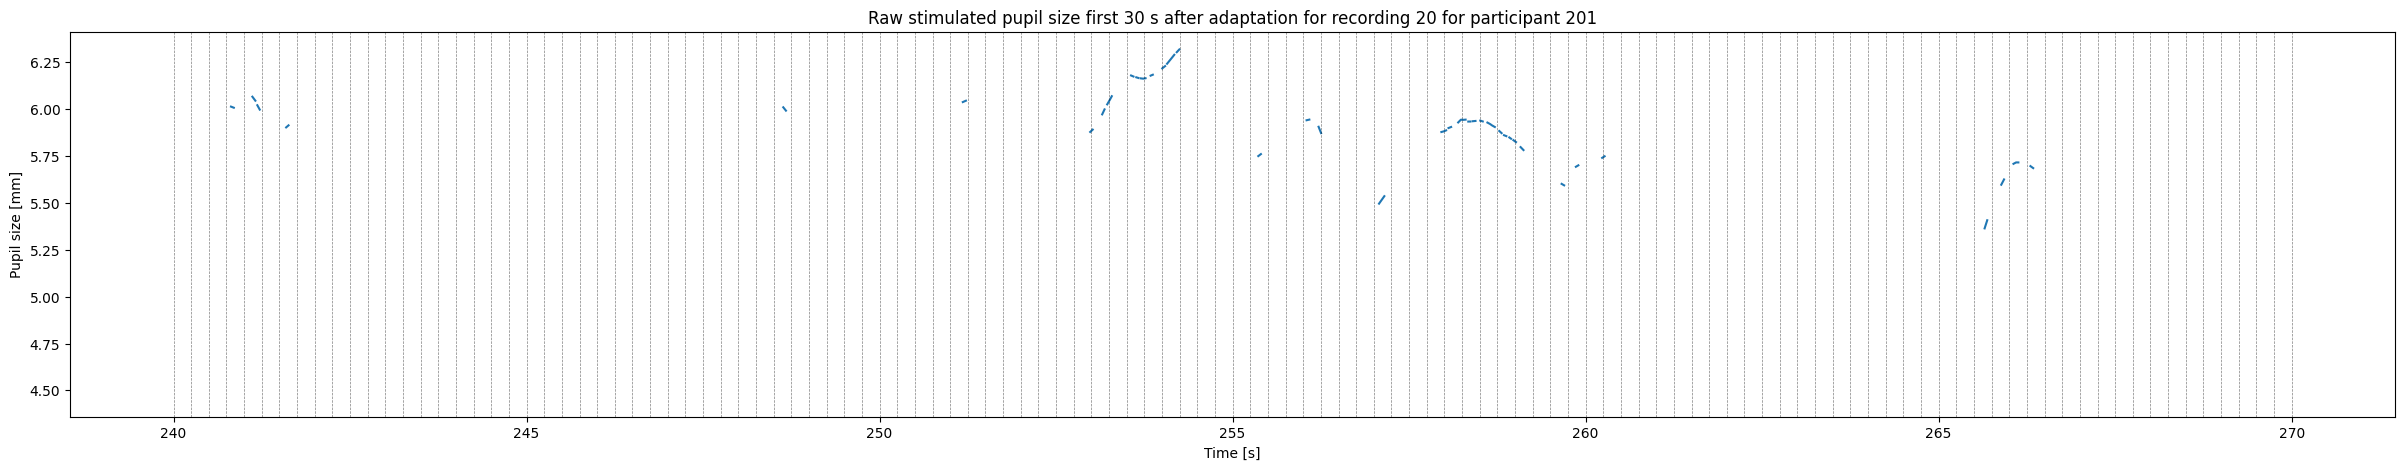

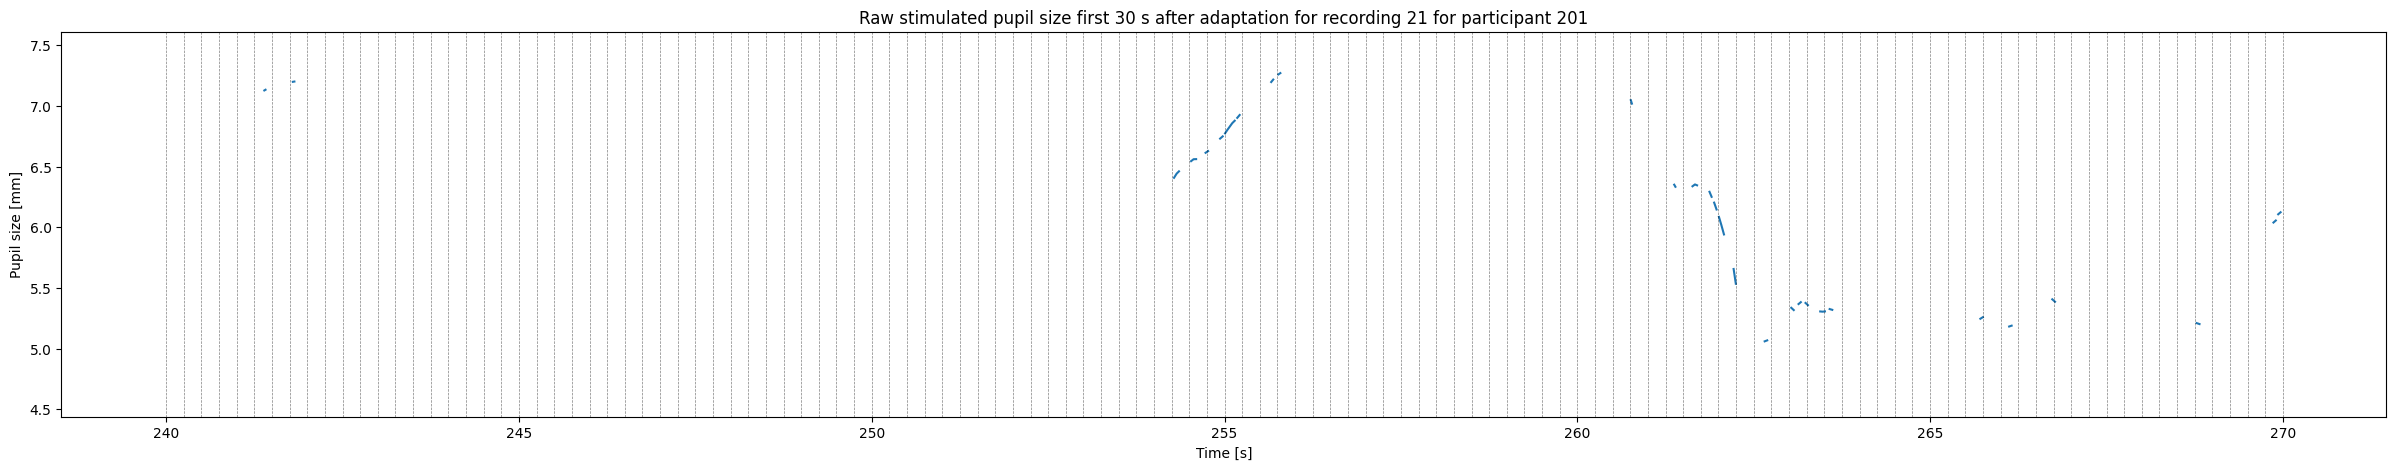

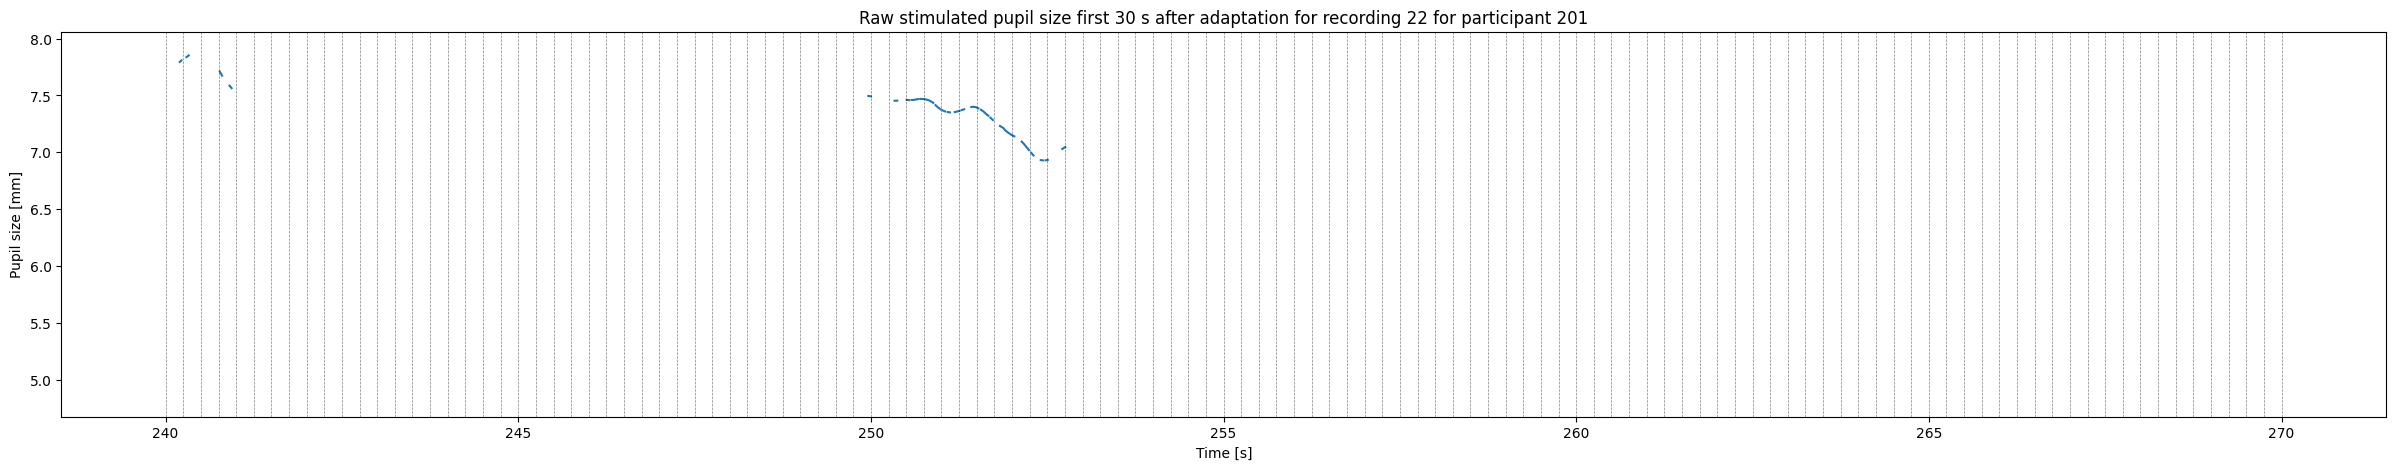

In [24]:
for recording in sorted(data_df['Recording id'].unique()):
    plt.figure(figsize = (30,5))
    plt.plot(data_df['Overall time Sec'][(data_df['Overall time Sec']>240)&(data_df['Overall time Sec']<270)&(data_df['Recording id']==recording)],
             data_df['Stim eye - Size Mm'][(data_df['Overall time Sec']>240)&(data_df['Overall time Sec']<270)&(data_df['Recording id']==recording)])
    plt.xlabel('Time [s]')
    plt.ylabel('Pupil size [mm]')
    plt.title('Raw stimulated pupil size first 30 s after adaptation for recording '+str(recording)+' for participant '+str(participant_id))
    for i in quarter_second_list:
        plt.axvline(i,c='k',ls='--',lw = 0.5,alpha=0.5)
    plt.show()

In [ ]:
def find_consecutive_nans(trial):
    # find and make a series of found nan sequences
    nan_list = (
        trial["Stim eye - Size Mm"]
        .isnull()
        .astype(int)
        .groupby(trial["Stim eye - Size Mm"].notnull().astype(int).cumsum())
        .sum()
    )
    return nan_list

In [ ]:
blocks = np.arange(11)
data_dir = "./results/new/"
data_suffix = "_recording_data.csv"

for j, participant_id in enumerate(participant_list):
    data_path = os.path.join(data_dir, str(participant_id) + data_suffix)
    data_df = pd.read_csv(data_path)
    data_df = prep.remove_trials_below_percentage(
        data_df,
        baseline_threshold=40,
        poi_threshold=75,
        baseline_time=[-1, 0],
        poi_time=[0, 6],
    )

    fig, axs = plt.subplots(2, 6, figsize=(20, 6))

    for block in blocks:
        nan_sequence_lengths = []
        block_df = data_df[
            (data_df["Block"] == block)
            & (data_df["Trial time Sec"] >= 0)
            & (data_df["Trial time Sec"] <= 6)
        ]  # just for period of interest 0:6
        for i, trial_no in enumerate(sorted(data_df["Trial no"].unique())):
            trial = block_df[block_df["Trial no"] == trial_no]
            nan_list = find_consecutive_nans(trial)
            nan_list = nan_list[nan_list > 1]
            nan_sequence_lengths.append(nan_list)

        nan_lengths = pd.concat(nan_sequence_lengths)
        nan_sequence_df = pd.DataFrame()
        nan_sequence_df["NaN duration Sec"] = nan_lengths * (1 / 30)
        # the plotting is wrapped in try, except since ValueError was raised when there were no elements to plot
        try:
            sns.histplot(
                nan_sequence_df,
                x="NaN duration Sec",
                binwidth=0.1,
                ax=axs[block // 6, block % 6],
            )
            axs[block // 6, block % 6].set_title("Block " + str(block))
            axs[block // 6, block % 6].set_xlim([0, 1.5])
            axs[block // 6, block % 6].set_ylim([0, 45])
            if block != 0 or block != 6:
                axs[block // 6, block % 6].set_ylabel("")
            if block < 6:
                axs[block // 6, block % 6].set_xlabel("")
        except ValueError:
            continue
    fig.suptitle(
        "Histograms of NaN sequence durations > 1 samples in poi post-threshold for participant "
        + str(participant_id)
    )
    plt.tight_layout()
    plt.show()